# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [4]:
!pip install datasets

Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [8]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [9]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [11]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [12]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [13]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

In [15]:
class Network(nn.Module):
  def __init__(self, hidden_dim: int, dropout: float, vocab_size: int,
               num_classes: int = 4, agregation_type: str = 'max'):
      super().__init__()

      self.embedding = nn.Embedding(vocab_size, hidden_dim)
      self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
      self.fc =  nn.Linear(hidden_dim, hidden_dim)
      self.tanh = nn.Tanh()
      self.dropout = nn.Dropout(dropout)
      self.out = nn.Linear(hidden_dim, num_classes)

      self.agregation_type = agregation_type

  def forward(self, input):
    x = self.embedding(input)
    output, _ = self.rnn(x)

    if self.agregation_type == 'max':
      output = output.max(dim=1)[0]
    elif self.agregation_type == 'mean':
      output = output.mean(dim=1)
    else:
      raise ValueError(f'Unknown agregation type: {self.agregation_type}')

    x = self.tanh(x)
    x = self.fc(output)
    x = self.dropout(x)
    x = self.tanh(x)
    output = self.out(x)


    return output



In [19]:
def train_model(model, data, n_epochs=5, eval_steps=None):
  if eval_steps is None:
    eval_steps = len(train_dataloader) // 2

  losses = []
  acc = []
  model.to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(n_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(data, desc=f'Training epoch {epoch}:')):
      optimizer.zero_grad()
      logits = model(batch['input_ids'])
      loss = criterion(logits, batch['label'])
      loss.backward()
      optimizer.step()
      epoch_losses.append(loss.item())

      if i % eval_steps == 0:
        model.eval()
        acc.append(evaluate(model, eval_dataloader))
        model.train()

    losses.append(np.mean(epoch_losses))

  return losses, acc

In [57]:
from collections import defaultdict

hidden_set = {129, 258, 516}

losses_type = defaultdict(list)
accuracies_type = defaultdict(list)
total_accuracy = np.zeros(len(hidden_set))

for i, num in enumerate(hidden_set):
    model_rnn_max = Network(num, 0.1, len(vocab), agregation_type='max')
    losses_rnn_max, accuracies_rnn_max = train_model(model_rnn_max, train_dataloader)

    model_rnn_mean = Network(num, 0.1, len(vocab), agregation_type='mean')
    losses_rnn_mean, accuracies_rnn_mean = train_model(model_rnn_mean, train_dataloader)

    print(f'Step for hidden layer with dim: {num}')

    # defaultdict автоматически создает списки
    losses_type['max'].append(losses_rnn_max)
    losses_type['mean'].append(losses_rnn_mean)

    accuracies_type['max'].append(accuracies_rnn_max)
    accuracies_type['mean'].append(accuracies_rnn_mean)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Step for hidden layer with dim: 129


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Step for hidden layer with dim: 258


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Step for hidden layer with dim: 516


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_analysis(losses_type, accuracies_type, hidden_set):
    """
    Функция для построения комплексных графиков анализа обучения

    Args:
        losses_type: словарь с потерями {'max': [list], 'mean': [list]}
        accuracies_type: словарь с accuracy {'max': [list], 'mean': [list]}
        hidden_set: множество hidden dimensions
    """

    # 1. Графики потерь (losses) для разных hidden_dim и агрегаций
    plt.figure(figsize=(15, 10))

    # График 1: Потери для max агрегации
    plt.subplot(2, 2, 1)
    for i, (hidden_dim, losses) in enumerate(zip(hidden_set, losses_type['max'])):
        plt.plot(losses, label=f'hidden_dim={hidden_dim}', linewidth=2)
    plt.title('Training Loss (Max Aggregation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График 2: Потери для mean агрегации
    plt.subplot(2, 2, 2)
    for i, (hidden_dim, losses) in enumerate(zip(hidden_set, losses_type['mean'])):
        plt.plot(losses, label=f'hidden_dim={hidden_dim}', linewidth=2)
    plt.title('Training Loss (Mean Aggregation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График 3: Accuracy для max агрегации
    plt.subplot(2, 2, 3)
    for i, (hidden_dim, accuracies) in enumerate(zip(hidden_set, accuracies_type['max'])):
        plt.plot(accuracies, label=f'hidden_dim={hidden_dim}', linewidth=2, marker='o', markersize=3)
    plt.title('Validation Accuracy (Max Aggregation)')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График 4: Accuracy для mean агрегации
    plt.subplot(2, 2, 4)
    for i, (hidden_dim, accuracies) in enumerate(zip(hidden_set, accuracies_type['mean'])):
        plt.plot(accuracies, label=f'hidden_dim={hidden_dim}', linewidth=2, marker='s', markersize=3)
    plt.title('Validation Accuracy (Mean Aggregation)')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 2. Сравнительные графики для разных агрегаций при одинаковых hidden_dim
    plt.figure(figsize=(15, 10))

    for i, hidden_dim in enumerate(hidden_set):
        plt.subplot(2, 2, i+1)

        # Потери
        max_losses = losses_type['max'][i]
        mean_losses = losses_type['mean'][i]

        plt.plot(max_losses, label='Max Aggregation', linewidth=2, color='red')
        plt.plot(mean_losses, label='Mean Aggregation', linewidth=2, color='blue')
        plt.title(f'Loss Comparison (hidden_dim={hidden_dim})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 3. Сравнительные графики accuracy
    plt.figure(figsize=(15, 10))

    for i, hidden_dim in enumerate(hidden_set):
        plt.subplot(2, 2, i+1)

        # Accuracy
        max_acc = accuracies_type['max'][i]
        mean_acc = accuracies_type['mean'][i]

        plt.plot(max_acc, label='Max Aggregation', linewidth=2, color='red', marker='o', markersize=3)
        plt.plot(mean_acc, label='Mean Aggregation', linewidth=2, color='blue', marker='s', markersize=3)
        plt.title(f'Accuracy Comparison (hidden_dim={hidden_dim})')
        plt.xlabel('Evaluation Step')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 4. Финальные accuracy для всех комбинаций
    plt.figure(figsize=(12, 6))

    final_accuracies_max = [acc[-1] for acc in accuracies_type['max']]
    final_accuracies_mean = [acc[-1] for acc in accuracies_type['mean']]

    x_pos = np.arange(len(hidden_set))
    width = 0.35

    plt.bar(x_pos - width/2, final_accuracies_max, width, label='Max Aggregation', alpha=0.8)
    plt.bar(x_pos + width/2, final_accuracies_mean, width, label='Mean Aggregation', alpha=0.8)

    plt.xlabel('Hidden Dimension')
    plt.ylabel('Final Accuracy')
    plt.title('Final Validation Accuracy by Hidden Dimension and Aggregation Type')
    plt.xticks(x_pos, [f'{dim}' for dim in hidden_set])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for i, v in enumerate(final_accuracies_max):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(final_accuracies_mean):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 5. Heatmap итоговых результатов
    plt.figure(figsize=(10, 6))

    # Создаем матрицу для heatmap
    accuracy_matrix = np.array([final_accuracies_max, final_accuracies_mean])
    aggregation_types = ['Max', 'Mean']
    hidden_dims_list = list(hidden_set)

    # Heatmap
    im = plt.imshow(accuracy_matrix, cmap='YlGnBu', aspect='auto')

    # Настройки осей
    plt.xticks(np.arange(len(hidden_dims_list)), hidden_dims_list)
    plt.yticks(np.arange(len(aggregation_types)), aggregation_types)
    plt.xlabel('Hidden Dimension')
    plt.ylabel('Aggregation Type')
    plt.title('Final Accuracy Heatmap')

    # Добавляем значения в ячейки
    for i in range(len(aggregation_types)):
        for j in range(len(hidden_dims_list)):
            text = plt.text(j, i, f'{accuracy_matrix[i, j]:.3f}',
                           ha="center", va="center", color="black", fontweight='bold')

    plt.colorbar(im, label='Accuracy')
    plt.tight_layout()
    plt.show()

    # 6. Сводная таблица результатов
    print("Сводная таблица результатов:")
    print("=" * 60)
    print(f"{'Hidden Dim':<12} {'Aggregation':<15} {'Final Accuracy':<15} {'Min Loss':<10}")
    print("-" * 60)

    for i, hidden_dim in enumerate(hidden_set):
        max_acc = accuracies_type['max'][i][-1]
        mean_acc = accuracies_type['mean'][i][-1]
        max_loss = min(losses_type['max'][i])
        mean_loss = min(losses_type['mean'][i])

        print(f"{hidden_dim:<12} {'Max':<15} {max_acc:<15.4f} {max_loss:<10.4f}")
        print(f"{hidden_dim:<12} {'Mean':<15} {mean_acc:<15.4f} {mean_loss:<10.4f}")
        print("-" * 60)

    # 7. График скорости сходимости (сколько шагов до достижения 80% accuracy)
    plt.figure(figsize=(10, 6))

    for i, hidden_dim in enumerate(hidden_set):
        # Для max агрегации
        max_acc = accuracies_type['max'][i]
        steps_to_80_max = next((j for j, acc in enumerate(max_acc) if acc >= 0.8), len(max_acc))

        # Для mean агрегации
        mean_acc = accuracies_type['mean'][i]
        steps_to_80_mean = next((j for j, acc in enumerate(mean_acc) if acc >= 0.8), len(mean_acc))

        plt.bar(f'{hidden_dim}\n(Max)', steps_to_80_max, alpha=0.7, label=f'Max {hidden_dim}', color='lightcoral')
        plt.bar(f'{hidden_dim}\n(Mean)', steps_to_80_mean, alpha=0.7, label=f'Mean {hidden_dim}', color='lightblue')

    plt.xlabel('Model Configuration')
    plt.ylabel('Steps to Reach 80% Accuracy')
    plt.title('Convergence Speed (Steps to Reach 80% Accuracy)')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


# Пример использования функции:
def run_analysis_for_model(model_name, losses_type, accuracies_type, hidden_set):
    """
    Запуск анализа для конкретной модели

    Args:
        model_name: название модели (для заголовков)
        losses_type: словарь с потерями
        accuracies_type: словарь с accuracy
        hidden_set: множество hidden dimensions
    """
    print(f"\n{'='*80}")
    print(f"АНАЛИЗ МОДЕЛИ: {model_name}")
    print(f"{'='*80}")

    plot_training_analysis(losses_type, accuracies_type, hidden_set)


# Функция для сравнения нескольких моделей
def compare_multiple_models(models_results):
    """
    Сравнение нескольких моделей

    Args:
        models_results: словарь в формате:
            {
                'model1_name': {
                    'losses_type': {...},
                    'accuracies_type': {...}
                },
                'model2_name': {
                    'losses_type': {...},
                    'accuracies_type': {...}
                },
                ...
            }
    """
    for model_name, results in models_results.items():
        run_analysis_for_model(
            model_name,
            results['losses_type'],
            results['accuracies_type'],
            results['hidden_set']
        )



if __name__ == "__main__":
    plot_training_analysis(losses_type, accuracies_type, hidden_set)



NameError: name 'losses_type' is not defined

In [69]:
class Lstm_Network(Network):
  def __init__(self, hidden_dim: int, dropout: float, vocab_size: int,
               num_classes: int = 4, agregation_type: str = 'max', num_layers: int = 1):
      super().__init__(hidden_dim, dropout, vocab_size, num_classes, agregation_type)
      self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers, bidirectional=True)
      # Adjust linear layers to handle doubled hidden dimension from bidirectional LSTM
      self.fc =  nn.Linear(hidden_dim * 2, hidden_dim)
      self.out = nn.Linear(hidden_dim, num_classes)

  def forward(self, input):
    x = self.embedding(input)
    output, _ = self.rnn(x)

    if self.agregation_type == 'max':
      output = output.max(dim=1)[0]
    elif self.agregation_type == 'mean':
      output = output.mean(dim=1)
    else:
      raise ValueError(f'Unknown agregation type: {self.agregation_type}')

    # Pass aggregated output through dense layers
    x = self.fc(output)
    x = self.tanh(x)
    x = self.dropout(x)
    output = self.out(x)

    return output



In [70]:
from collections import defaultdict

hidden_set = {129, 258, 516}

losses_type_1 = defaultdict(list)
accuracies_type_1 = defaultdict(list)
total_accuracy = np.zeros(len(hidden_set))

for i, num in enumerate(hidden_set):
    model_rnn_max = Lstm_Network(num, 0.1, len(vocab), agregation_type='max')
    losses_rnn_max, accuracies_rnn_max = train_model(model_rnn_max, train_dataloader)

    model_rnn_mean = Lstm_Network(num, 0.1, len(vocab), agregation_type='mean')
    losses_rnn_mean, accuracies_rnn_mean = train_model(model_rnn_mean, train_dataloader)

    print(f'Step for hidden layer with dim: {num}')

    # defaultdict автоматически создает списки
    losses_type_1['max'].append(losses_rnn_max)
    losses_type_1['mean'].append(losses_rnn_mean)

    accuracies_type_1['max'].append(accuracies_rnn_max)
    accuracies_type_1['mean'].append(accuracies_rnn_mean)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Step for hidden layer with dim: 129


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Step for hidden layer with dim: 258


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Step for hidden layer with dim: 516


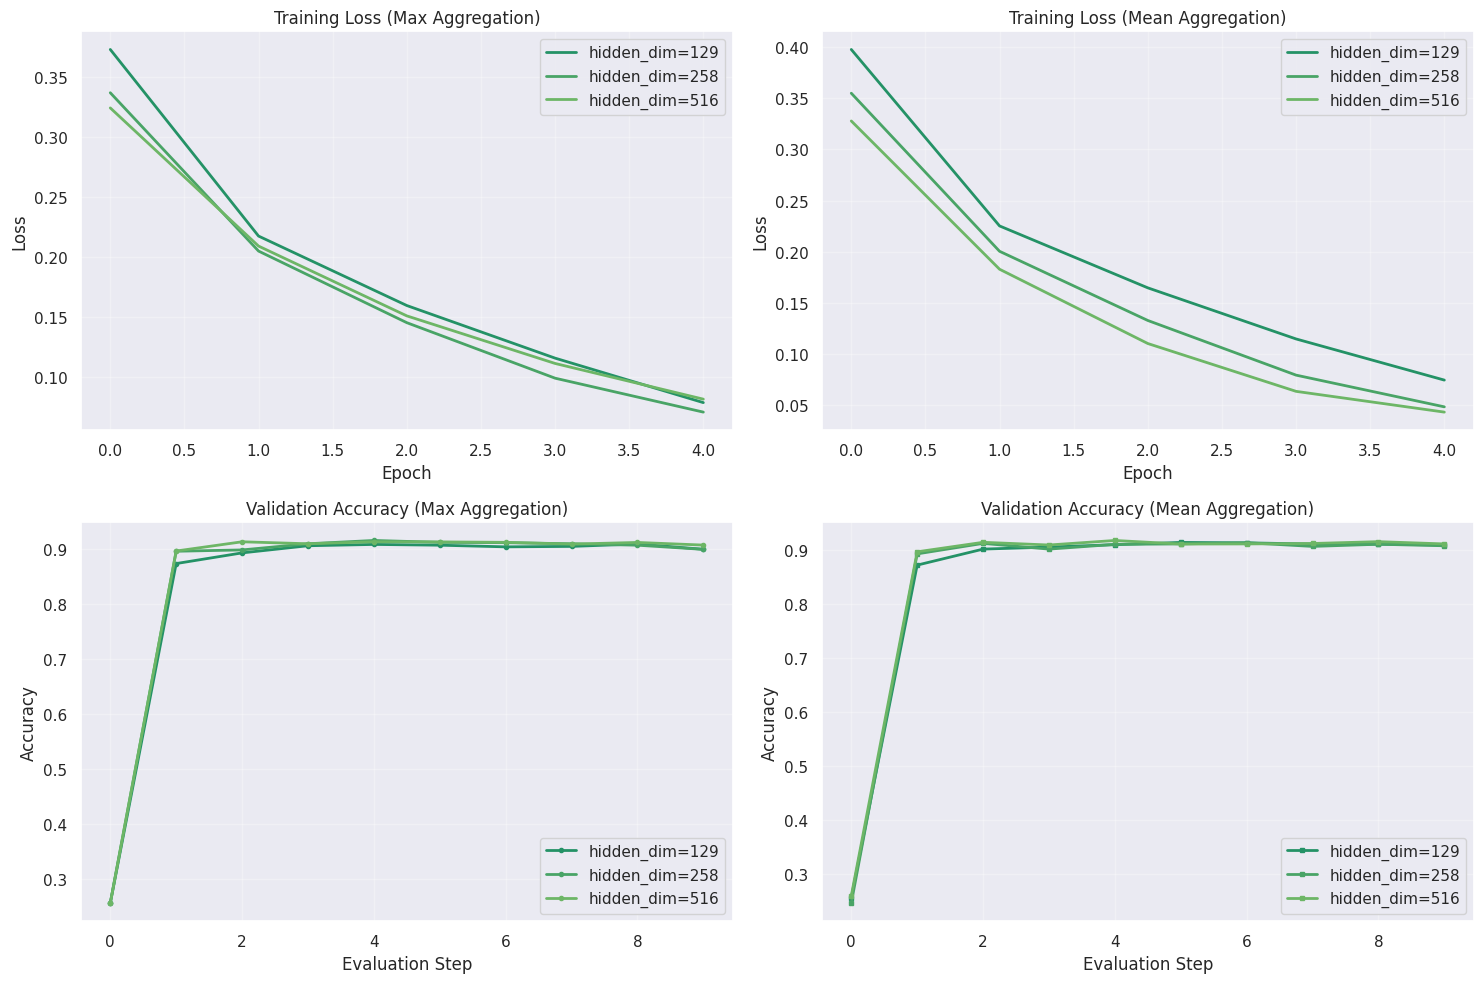

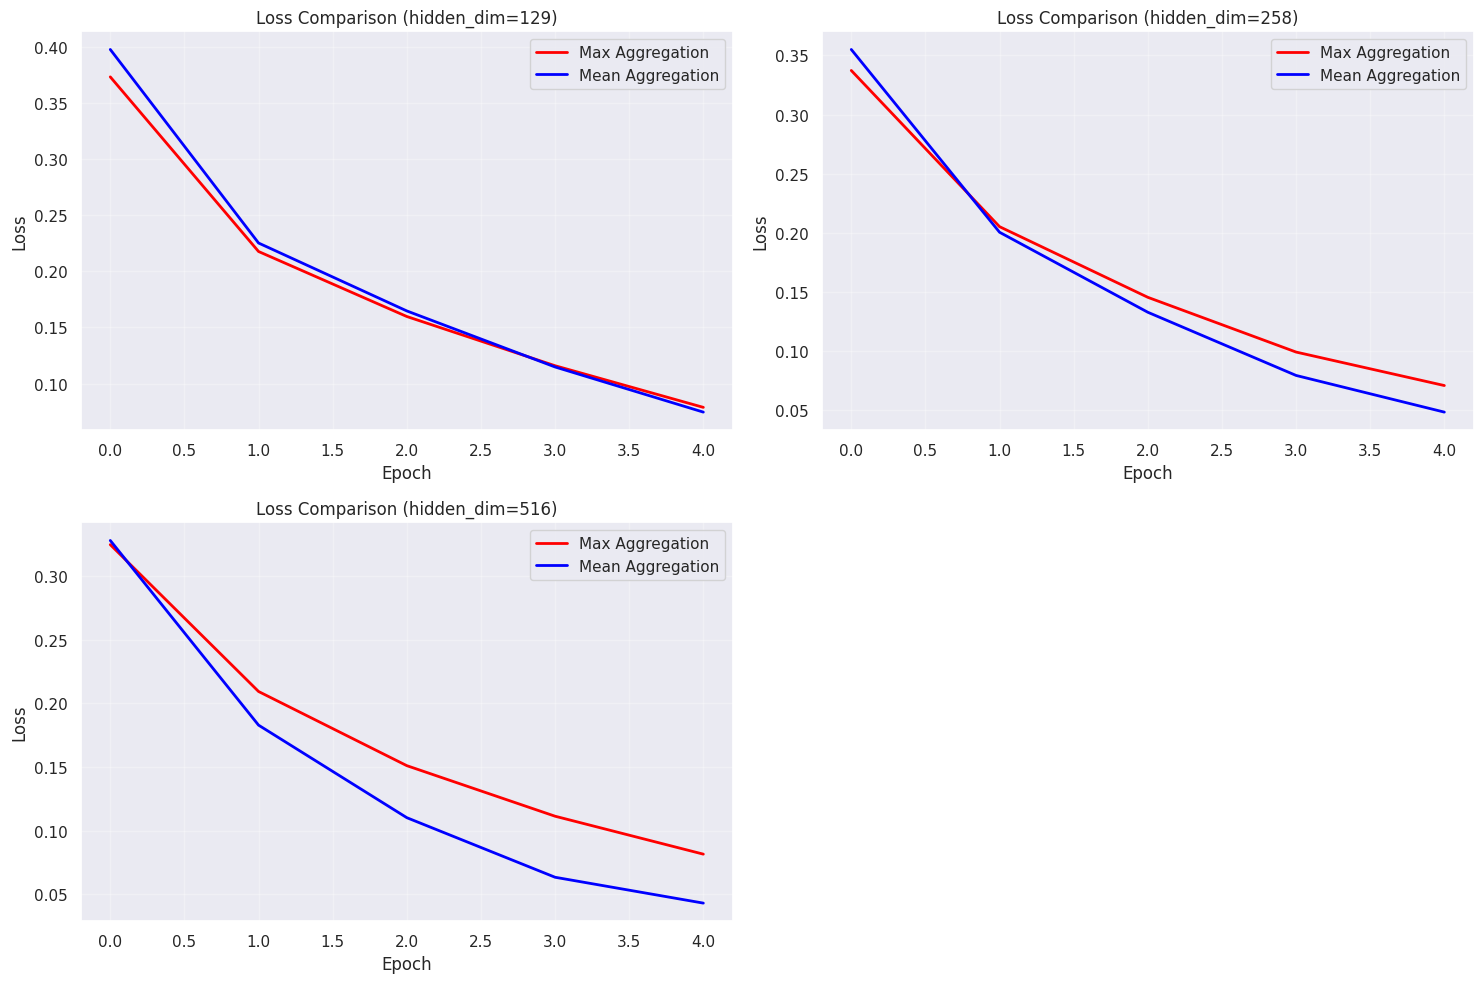

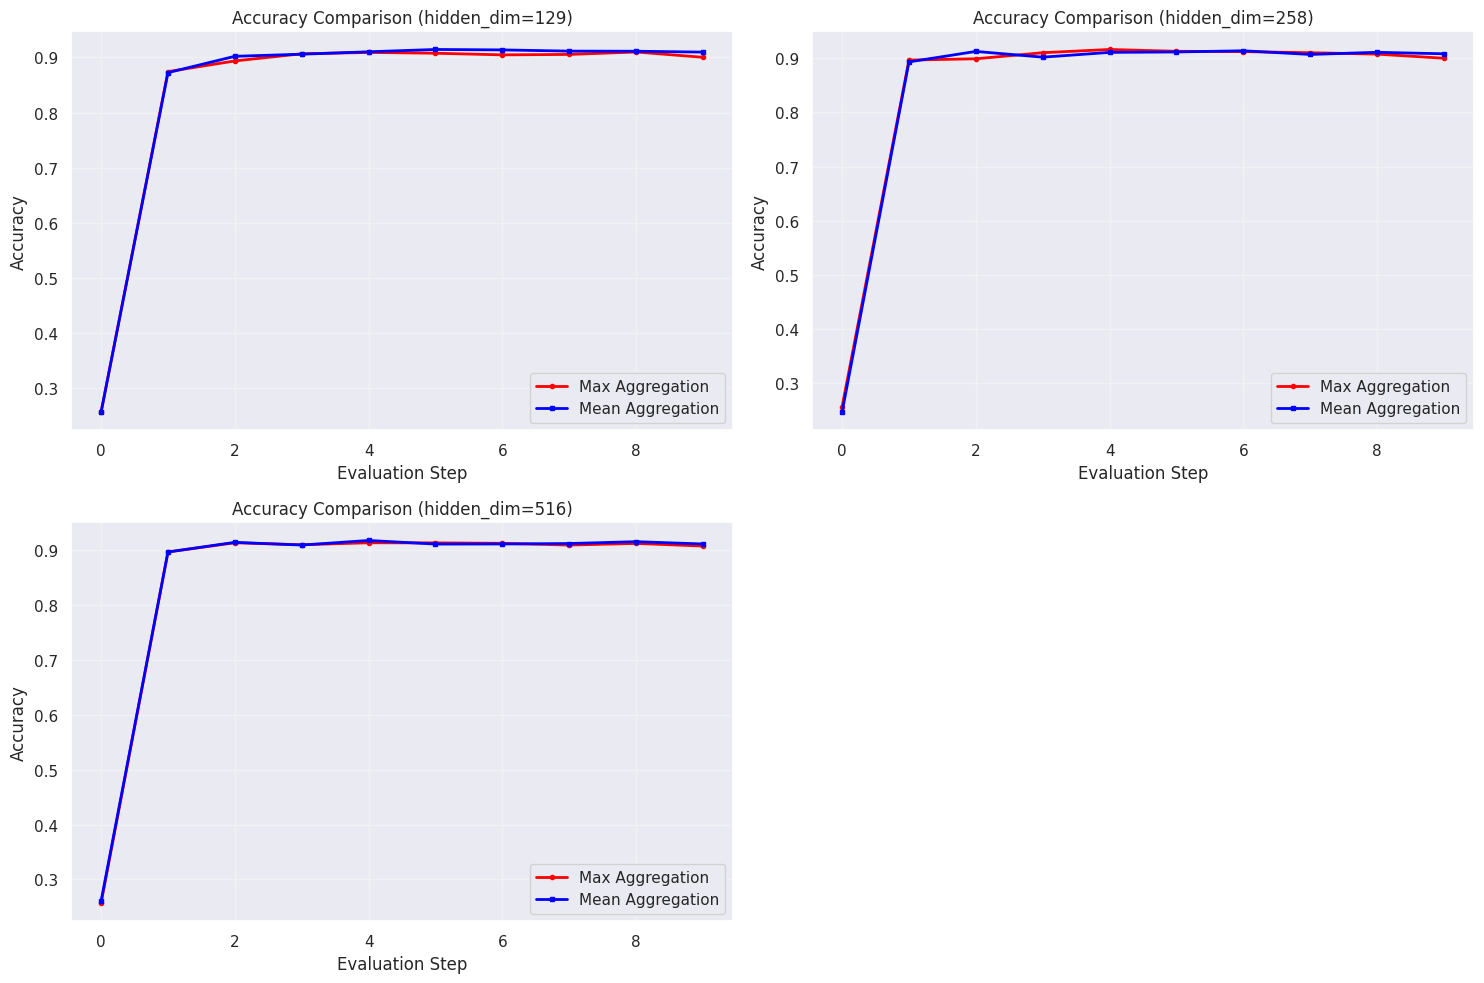

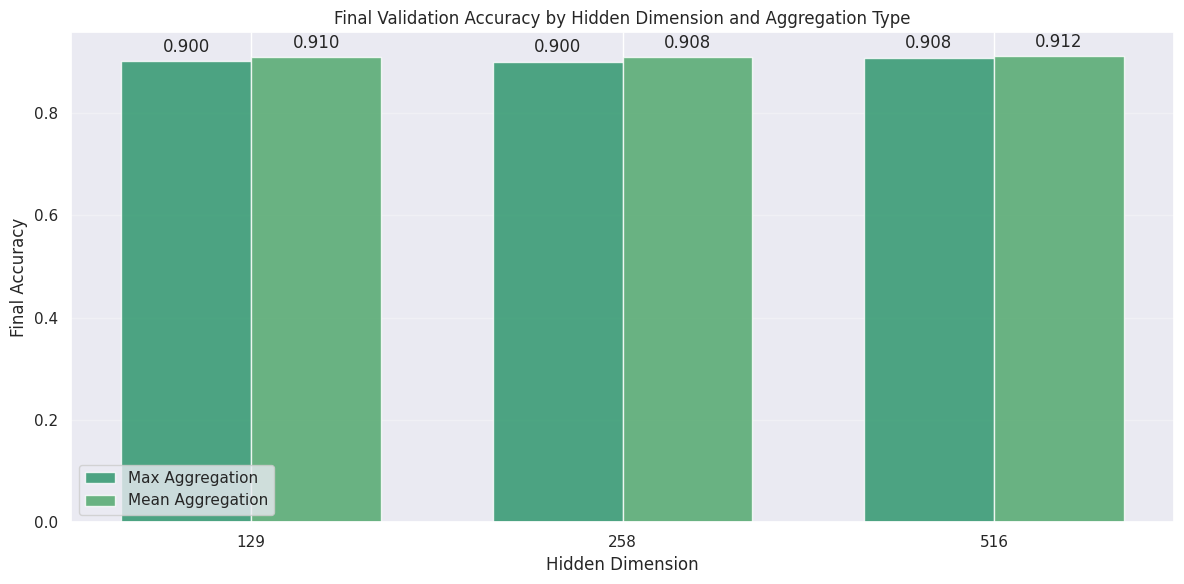

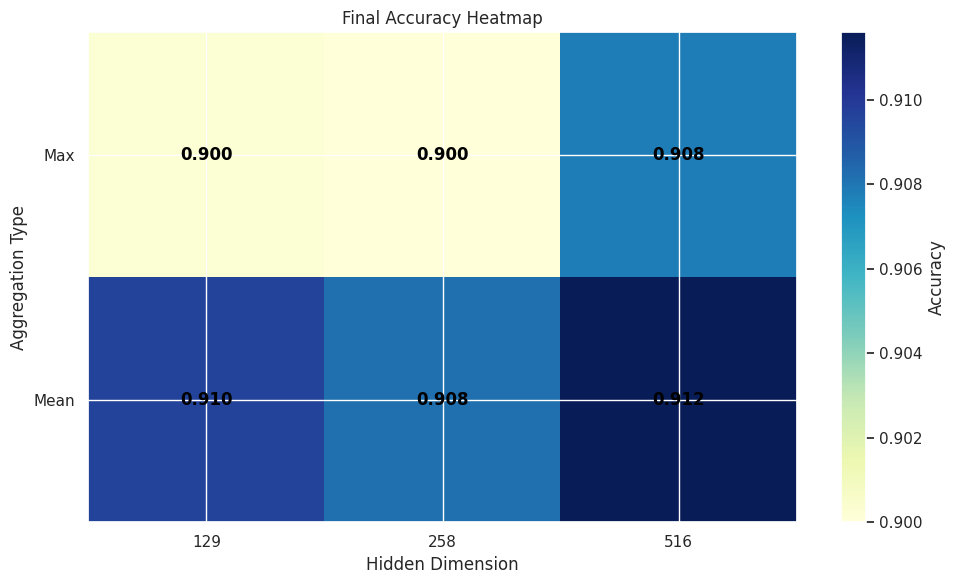

Сводная таблица результатов:
Hidden Dim   Aggregation     Final Accuracy  Min Loss  
------------------------------------------------------------
129          Max             0.9002          0.0788    
129          Mean            0.9096          0.0745    
------------------------------------------------------------
258          Max             0.9000          0.0709    
258          Mean            0.9082          0.0484    
------------------------------------------------------------
516          Max             0.9078          0.0817    
516          Mean            0.9116          0.0432    
------------------------------------------------------------


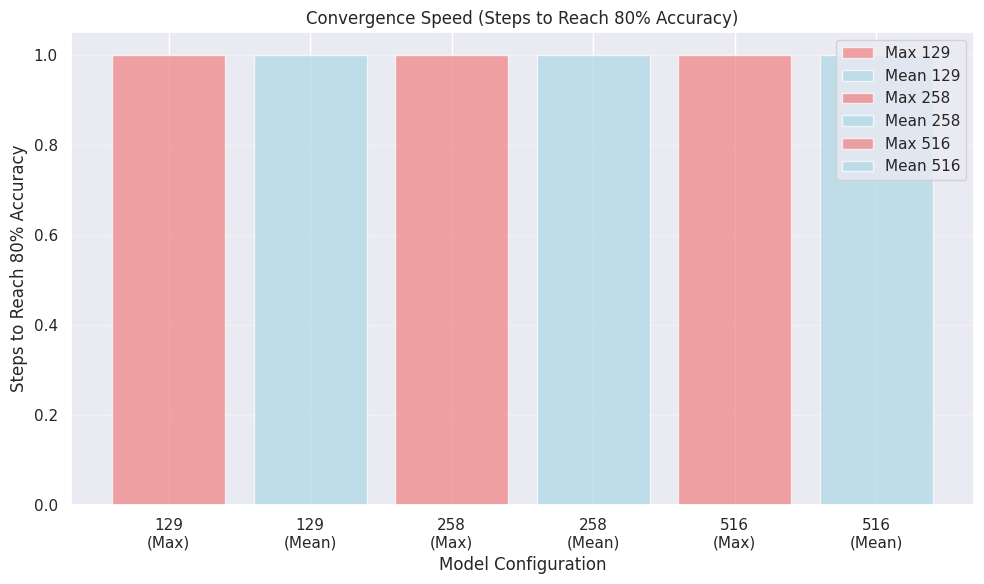

In [71]:
if __name__ == "__main__":
    plot_training_analysis(losses_type_1, accuracies_type_1, hidden_set)

In [16]:
class Gru_Network(Network):
  def __init__(self, hidden_dim: int, dropout: float, vocab_size: int,
               num_classes: int = 4, agregation_type: str = 'max', num_layers: int = 1):
      super().__init__(hidden_dim, dropout, vocab_size, num_classes, agregation_type)
      self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers, bidirectional=True)
      # Adjust linear layers to handle doubled hidden dimension from bidirectional GRU
      self.fc =  nn.Linear(hidden_dim * 2, hidden_dim)
      self.out = nn.Linear(hidden_dim, num_classes)

  def forward(self, input):
    x = self.embedding(input)
    output, _ = self.rnn(x)

    if self.agregation_type == 'max':
      output = output.max(dim=1)[0]
    elif self.agregation_type == 'mean':
      output = output.mean(dim=1)
    else:
      raise ValueError(f'Unknown agregation type: {self.agregation_type}')

    # Pass aggregated output through dense layers
    x = self.fc(output)
    x = self.tanh(x)
    x = self.dropout(x)
    output = self.out(x)

    return output

In [21]:
from collections import defaultdict

hidden_set = {129, 258, 516}

losses_type_2 = defaultdict(list)
accuracies_type_2 = defaultdict(list)
total_accuracy = np.zeros(len(hidden_set))

for i, num in enumerate(hidden_set):
    model_rnn_max = Gru_Network(num, 0.1, len(vocab), agregation_type='max')
    losses_rnn_max, accuracies_rnn_max = train_model(model_rnn_max, train_dataloader)

    model_rnn_mean = Gru_Network(num, 0.1, len(vocab), agregation_type='mean')
    losses_rnn_mean, accuracies_rnn_mean = train_model(model_rnn_mean, train_dataloader)

    print(f'Step for hidden layer with dim: {num}')


    losses_type_2['max'].append(losses_rnn_max)
    losses_type_2['mean'].append(losses_rnn_mean)

    accuracies_type_2['max'].append(accuracies_rnn_max)
    accuracies_type_2['mean'].append(accuracies_rnn_mean)

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    plot_training_analysis(losses_type_2, accuracies_type_2, hidden_set)